In [1]:
import tsunami_symulation as ts

import os
os.environ["NUMBA_THREADING_LAYER"] = "omp"

import numba
import sys
# if 'google.colab' in sys.modules:
#     !pip --quiet install open-atmos-jupyter-utils
#     from open_atmos_jupyter_utils import pip_install_on_colab
#     pip_install_on_colab('PyMPDATA-examples')
# !pip install PyMPDATA
# !pip install --quiet pint

import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

# Badanie przejścia fali tsunami przez stok kontynentalny

## Wstęp

Przeprowadzono symulację przejścia fali tsunami przez stok kontynentalny. W tym celu wykorzystano równania płytkiej wody, zaimplementowane przy pomocy pakietu pyMPDATA. Wszytskie wykorzystane klasy i funkcje znajdują się w pliku "tsunami_symulation.py". W symualacji posłużono się następującymi wielkościami fizycznymi i jednostkami:

$$ h \rightarrow \text{głębokość oceanu (bathymetria) wyrażona w kilometrach,} $$
$$ \eta \rightarrow \text{Wysokość fali tsunami mierzona w metrach,} $$
$$ y \rightarrow \text{Odległość od wybrzeża mierzona w kilometrach,} $$
$$ t \rightarrow \text{Czas mierzony w minutach,} $$
$$ v \rightarrow \text{Prędkość fali tsunami w kierunku $y$ mierzona w km/h,} $$
$$ g \rightarrow \text{Stała grawitacji wyrażona w km/min$^2$,} $$
$$ dt\text{\_over\_}dxy \rightarrow \text{Stosunek kroku czasowego do przestrzennego wyrażony w min/km.} $$

Stosunek kroków czasowych wylicza się na podstawie przewidywanej prędkości fali i siatki przestrzennej tak, aby wartość liczby Couranta, dla przewidywanej prędkości, była równa około 0.5. Za powyższe odpowiada funkcja "calc\_dt\_over\_dxdy\_and\_g".

## Warunki symulacji

Bathymatria oraz głębokość oceanu, z uwzględnieniem zaburzenia, generowane są odpowiednio poprzez funkcje "generate\_bathymetry" oraz "make_h_initial". 

Struktura dna imituje występujące powszechnie przejście pomiędzy płytą kontynentalną, a oceaniczną. W analizowanym przypadku szelf kontynentalny o głębokości 300 m sięga 150 km wgłąb oceanu, a następnie przechodzi w stok o długości 150 km. Basen oceaniczny ma głębokość równą 6 km.  

Wprowadzone zaburzenie odpowiada generacji fali tsunami w wyniku uskoku tektonicznego, w odległości 600 km od brzegu. W analizowanym przypadku uskok spowodował podniesienie się części dna (od strony brzegu) o 7 metrów oraz spadek o 4 metry. Powstałe zaburzenie obejmuje obszar rozciągający się na 200 km w kierunku równoległym i 50 km w kierunku prostopadłym do brzegu i jest reprezentowane jako suma dwóch funkcji Gaussa.

In [2]:
grid = (1501, 1501)
outfreq = 20
L_km = 1000.0
shelf_end=150
slope_end=300
v_tsunami = 800.0

dt_over_dxy, dt, dx_km, dy_km, g = ts.calc_dt_over_dxdy_and_g(grid=grid, L_km=L_km, v_tsunami_km_per_h=v_tsunami, C=0.4)

bathymetry, X, Y, depth_y = ts.generate_bathymetry(
    grid = grid, x_width=L_km, y_width=L_km, depth_deep=6.0, depth_shelf=0.3,
    y_shelf_start=50, y_shelf_end=150, y_slope_end=300, draw_profile=False,
)

h_initial, vh_initial, uh_initial = ts.make_h_initial(
    bathymetry=bathymetry, X=X, Y=Y, uplift_amp_m = 7.0, subsidence_amp_m = 4.0,
    x_frac = 0.5, x_width_km = 200.0, y_frac = 0.6, y_width_km = 50.0, draw_profile=False,
)

dx = 0.67 km, dy = 0.67 km, dt = 0.02000, dt_over_dxy = 0.03000, 0.03000


NameError: name 'x_witdt_km' is not defined

In [ ]:
output = ts.ShallowWaterEquationsIntegrator(
    h_initial=h_initial, bathymetry=bathymetry, uh_initial=uh_initial, vh_initial=vh_initial
)(
    nt=2700,
    g=g,
    dt_over_dxy=dt_over_dxy,
    outfreq=outfreq
)

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
with open("tsunami_output_1501.npy", "wb") as f:
    np.save(f, output)
# with open("tsunami_output.npy", "rb") as f:
#     output = np.load(f, allow_pickle=True).item()

## Diagram czasoprzestrzenny

Rozchodzenie się fali w kierunku prostopadłym do brzegu przedstawiono na diagramie czasoprzestrzennym. Fala przemieszczając się przez basen oceaniczny, nie zmienia znacząco swoich parametrów, tj. dlugości, wysokości, prędkości. Przy przechodzeniu przez stok kontynentalny następuje wypiętrzenie się fali, wraz ze zmiejszeniem jej długości oraz wzrostem prędkości. Po osiągnięciu szelfu kotynentalnego paramtry na powrót się stabilizują. 

Do stabilnych obszarów czasoprzestrzeni dopasowano prostą, na podstwie której wyznaczono średnią prędkość fali w obszarze szelfu kontynentalnego i basenu oceanicznego.

$$ v_{\text{szelf}} = 195.8 \text{km/h} $$
$$ v_{\text{basen}} = 885.4 \text{km/h} $$

Teoretyczne prędkości fali tsunami można przewidzieć, kożystając ze wzoru:

$$v = \sqrt{gh}.$$

Dla badanych głębokości oczekiwanio więc wartości odpowiednio dla szelfu 197.18 km/h i dla basenu 881.8 km/h. Różnicę względne wynoszą $0.7\%$ dla szelfu i $0.4\%$, co świadczy o poprawności symulacji.

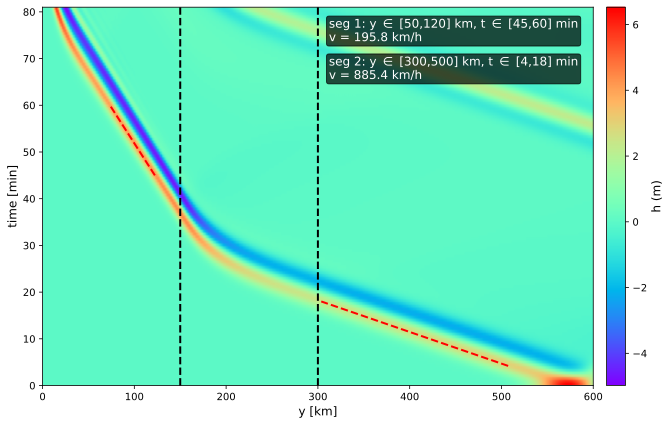

In [4]:
ts.plot_space_time_diagram(
    output=output,
    bathymetry=bathymetry, 
    y_coords=np.linspace(0, L_km, bathymetry.shape[1]), 
    dt=dt, 
    outfreq=outfreq, 
    slope_end=slope_end, 
    shelf_end=shelf_end,
    pos_segments=[
        (50, 120,  45, 60), 
        (300, 500, 4, 18)
    ],
    cmap="rainbow",
)

## Wysokość tsunami w zależności od czasu i głębokości

Zbadano zależność wysokości fali w funkcji czasu, wraz z porównaniem z bathymetrią. Na głębokim ocenanie wysokość fali osiąga niecałe 3 metry. Podczas przekraczania stoku kontynentalnego wysokość rośnie w przybliżeniu liniowo do około 4.5 metra. Natępnie poruszając się po plaskim szelfie wysokość fali nieznacznie maleje do 4 m, po czym rośnie znacząco przy zbliżaniu się do plaży. 

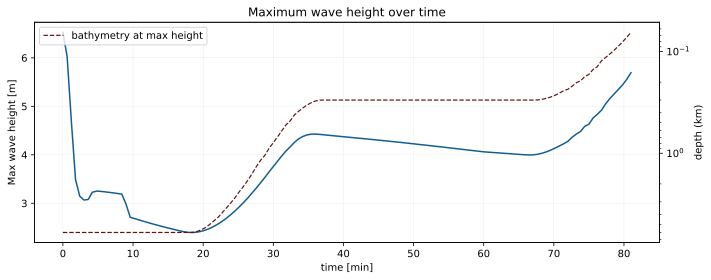

In [4]:
ts.animate_cross_section_y(
    output=output,
    bathymetry=bathymetry,
    y_coords=np.linspace(0, L_km, bathymetry.shape[1]),
    dt=dt,
    outfreq=outfreq,
    shelf_end=shelf_end,
    slope_end=slope_end,
    x_index=None,
    create_animation=False,
)

## Analiza zbieżności

Wyniki osiągnięte dla gęstości siatki (1001 $\times$ 1001) porównano z siatką (601 $\times$ 601). Interwał czasowy po jakim fala dotarła do stoku wynosi 20 minut. W okolicach 35 minuty wysokość osiąga maksimum przy wchodzeniu na szelf kontynentalny. Dla obu gęstości siatki maksimum wysokości wynosi około 4.5 metra.

Zgodność powyższych parametrów świadczy o zbieżności metody.

dx = 1.67 km, dy = 1.67 km, dt = 0.02500, dt_over_dxy = 0.01500, 0.01500


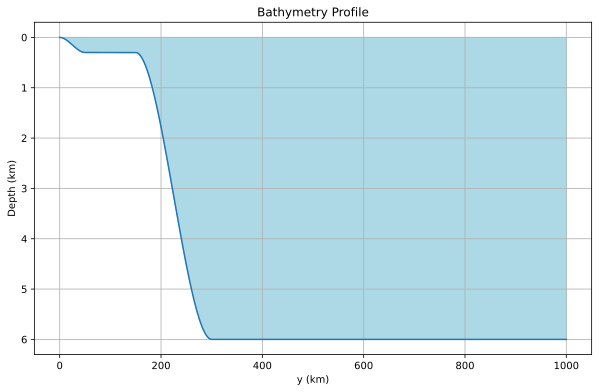


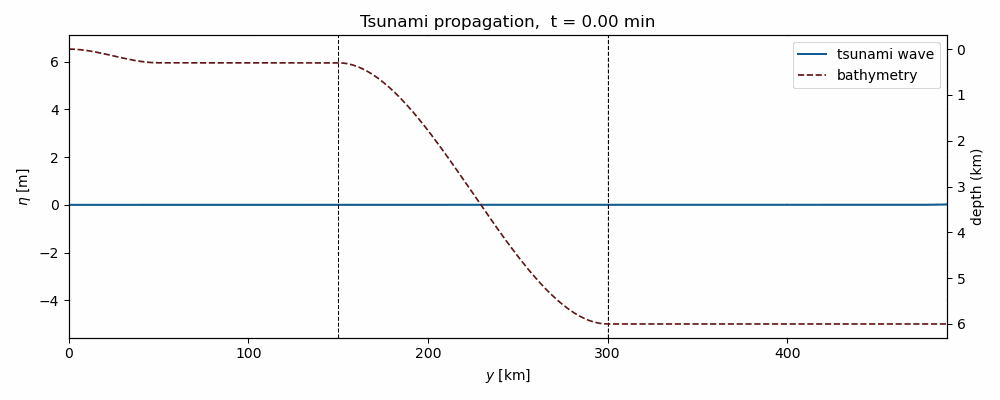

HTML(value="<a href='./tmpjhns3ymu.gif' target='_blank'>./tmpjhns3ymu.gif</a><br>")

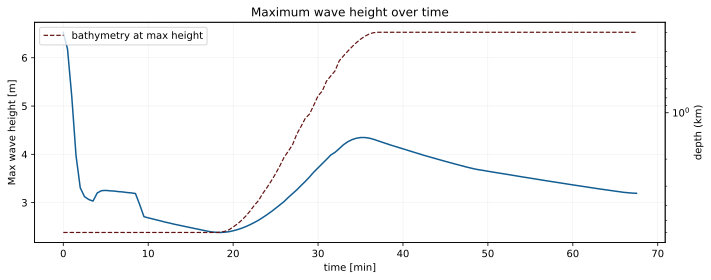

In [ ]:
grid = (601, 601)
outfreq = 20
L_km = 1000.0
shelf_end=150
slope_end=300
v_tsunami = 800.0

dt_over_dxy, dt, dx_km, dy_km, g = ts.calc_dt_over_dxdy_and_g(grid=grid, L_km=L_km, v_tsunami_km_per_h=v_tsunami, C=0.2)

bathymetry, X, Y, depth_y = ts.generate_bathymetry(
    grid = grid, x_width=L_km, y_width=L_km, depth_deep=6.0, depth_shelf=0.3,
    y_shelf_start=50, y_shelf_end=150, y_slope_end=300, draw_profile=False,
)

h_initial, vh_initial, uh_initial = ts.make_h_initial(
    bathymetry=bathymetry, X=X, Y=Y, uplift_amp_m = 7.0, subsidence_amp_m = 4.0,
    x_frac = 0.5, x_width_km = 200.0, y_frac = 0.6, y_width_km = 50.0, draw_profile=False,
)

with open("tsunami_output_501.npy", "rb") as f:
    output = np.load(f, allow_pickle=True).item()

ts.animate_cross_section_y(
    output=output, bathymetry=bathymetry, y_coords=np.linspace(0, L_km, bathymetry.shape[1]), dt=dt,
    outfreq=outfreq, shelf_end=shelf_end, slope_end=slope_end, x_index=None, create_animation=False,
)